In [1]:
import arrow
import learn2learn as l2l
import numpy as np
import os
import pickle
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
%run -i ./scripts/setConfigs.py

Set configs..


### Prepare dataset as PyTorch dataset

In [3]:
fn = os.path.join(data_path, 'drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data = pd.read_hdf(fn, key='df')
print('Shape of drifted data: {}'.format(df_data.shape))

Shape of drifted data: (35040, 18)


In [4]:
data_fn = os.path.join(data_path, 'simulation_data_y_2020_2021_reduced.h5')
df_data_sim = pd.read_hdf(data_fn, key='df')
print('Shape of simulation data: {}'.format(df_data_sim.shape))

Shape of simulation data: (105216, 17)


In [5]:
s_drift_labels = df_data['drift_labels']
s_drift_labels.reset_index(drop=True, inplace=True)
df_data.drop('drift_labels', axis=1, inplace=True)
print('Shape of drifted data: {}'.format(df_data.shape))

Shape of drifted data: (35040, 17)


In [6]:
print('Drift Labels: {}'.format(sorted(s_drift_labels.unique())))

Drift Labels: [0.0, 1.0, 2.0, 3.0]


In [7]:
### Scale data
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_sim)
scaled_drifted = scaler_train.transform(df_data.to_numpy())
del(df_data_sim)

Scale data..


In [8]:
df_data_scaled = pd.DataFrame(scaled_drifted)

In [9]:
# build tensor from numpy
drifted_torch_tensor_X = torch.from_numpy(df_data_scaled.to_numpy()).type(torch.FloatTensor)
drifted_torch_tensor_y = torch.from_numpy(s_drift_labels.to_numpy().reshape(len(s_drift_labels),1)).type(torch.FloatTensor)

In [10]:
# build pytorch dataset from tensor
drifted_dataset = TensorDataset(drifted_torch_tensor_X, drifted_torch_tensor_y)

### Load PyTorch Model

In [11]:
%run -i ./scripts/ReadSimpleAE.py

Load UNtrained simple AE..
/Users/torge/Development/master/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200302_firstAE_model.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


### Prepare Data for meta learning

In [12]:
data = l2l.data.MetaDataset(drifted_dataset)

In [13]:
# build l2l MetaDataset and TaskDataset for sampling
train_tasks = l2l.data.TaskDataset(data,
                                   task_transforms=[
                                        l2l.data.transforms.NWays(data, n=1),
                                        l2l.data.transforms.KShots(data, k=5),
                                        l2l.data.transforms.LoadData(data)],
                                   num_tasks=32)

In [14]:
eval_task = l2l.data.TaskDataset(data,
                                   task_transforms=[
                                        l2l.data.transforms.NWays(data, n=1),
                                        l2l.data.transforms.KShots(data, k=1),
                                        l2l.data.transforms.LoadData(data),
                                   ],
                                   num_tasks=1)

## Meta Learning

In [15]:
from MetaLearner.Learner import Learner

In [16]:
learner = Learner(model=model, train_task_dataset=train_tasks, eval_task_dataset=eval_task, num_iterations=400, optimizer='SGD')

In [17]:
learner.do_meta_learning()

Adaption Error: 86913.421875, Validation Error: 9259.553711: 100%|██████████| 400/400 [05:22<00:00,  1.24it/s]


## Training results

In [18]:
tmp_eval = learner.evaluation_loss
tmp_adapt = learner.adaption_loss

In [19]:
s_eval_loss = pd.Series(learner.evaluation_loss)
s_adapt_loss = pd.Series(learner.adaption_loss)

In [20]:
s_eval_loss.describe()

count    12800.000000
mean      1452.196546
std       3100.118423
min          0.003256
25%          0.011587
50%          0.020760
75%        440.805372
max      11822.245117
dtype: float64

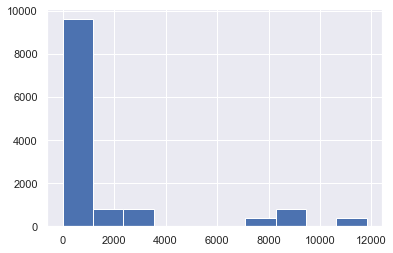

In [21]:
s_eval_loss.hist()

In [22]:
s_adapt_loss.describe()

count    128000.000000
mean      21130.988682
std       39536.620747
min           0.211262
25%           0.295887
50%           0.363312
75%        5672.969023
max      133611.828125
dtype: float64

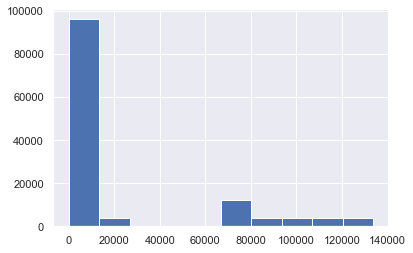

In [23]:
s_adapt_loss.hist()

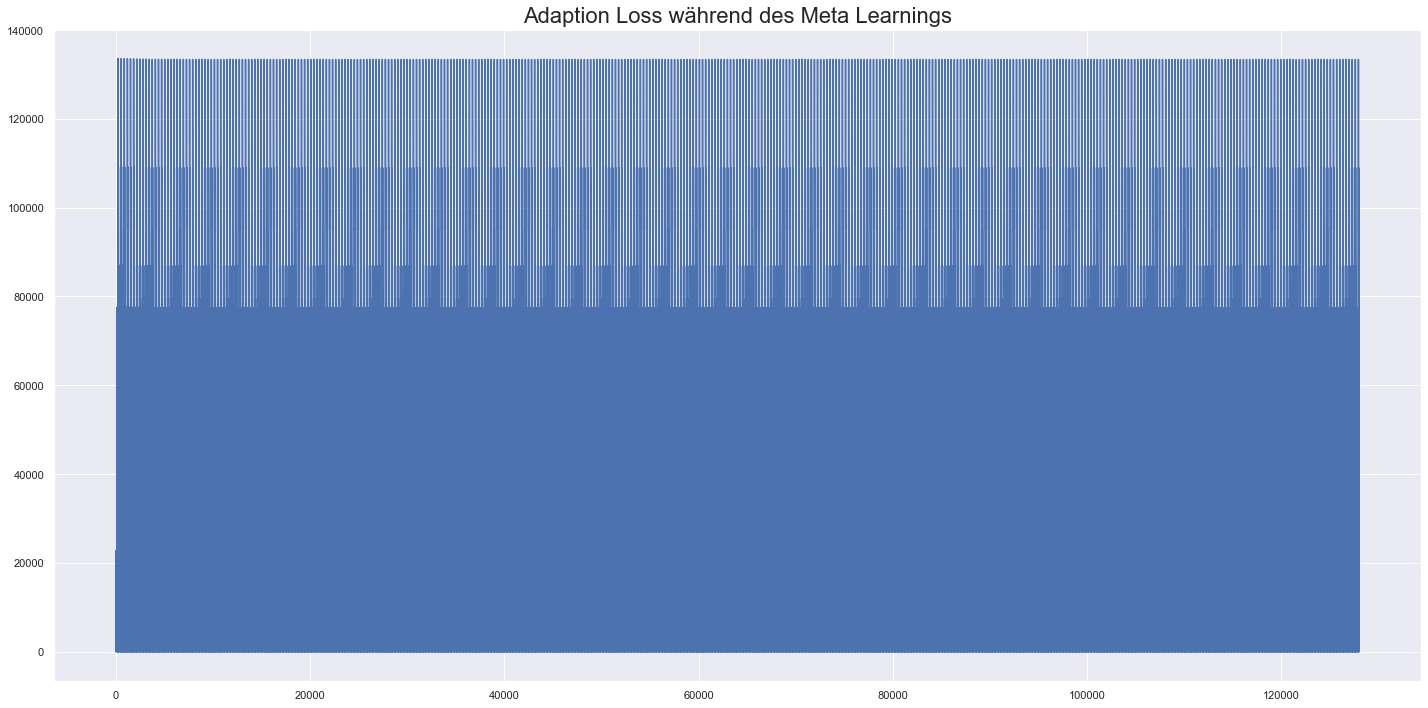

In [24]:
save_plot = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_title('Adaption Loss während des Meta Learnings', fontsize=22)

ax.plot(s_adapt_loss)
plt.tight_layout()

if save_plot:
    fn = os.path.join(fig_path, 'adaption_loss_meta_learning.pdf')
    fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

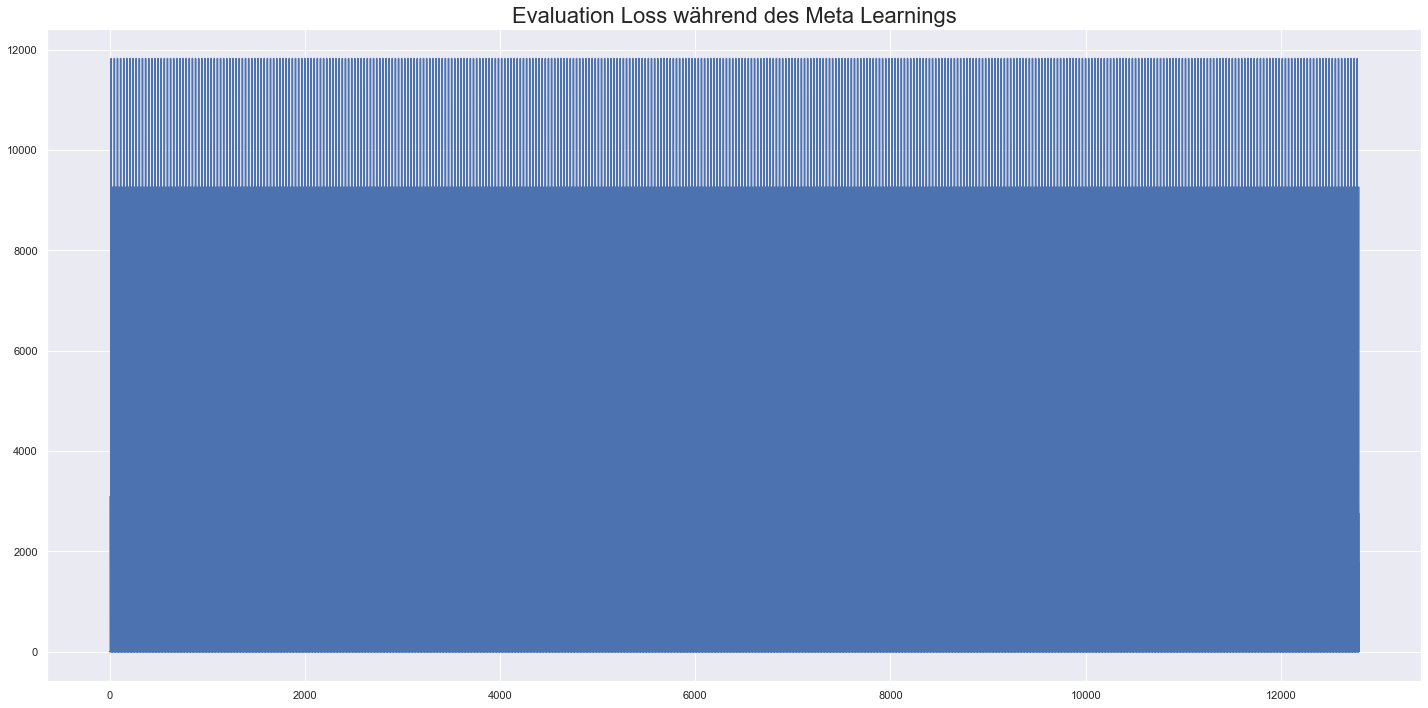

In [25]:
save_plot = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_title('Evaluation Loss während des Meta Learnings', fontsize=22)

ax.plot(s_eval_loss)
plt.tight_layout()

if save_plot:
    fn = os.path.join(fig_path, 'adaption_loss_meta_learning.pdf')
    fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

## Save adapted Meta Model

In [26]:
meta_model = learner.meta_model.module
print(type(meta_model))

<class 'models.SimpleAutoEncoder.SimpleAutoEncoder'>


In [27]:
model_fn = '{}_first_meta_model.pt'.format(arrow.now().format('YYYYMMDD'))
print('Model Name: {}'.format(model_fn))
torch.save(meta_model.state_dict(), os.path.join(model_bib_path, model_fn))

Model Name: 20200316_first_meta_model.pt


## Save Learner Classs as Pickle

In [28]:
# Delte data and models from Class for pickle
learner.meta_model = None
learner.model = None
learner.train_task_data = None
learner.eval_task_data = None

In [29]:
meta_model_fn = '{}_learner_class.pkl'.format(arrow.now().format('YYYYMMDD'))
print('Model Name: {}'.format(meta_model_fn))
fn = os.path.join(os.getcwd(), 'MetaLearner', 'save', meta_model_fn)

with open(fn, 'wb') as file:
    pickle.dump(learner, file)

Model Name: 20200316_learner_class.pkl
